In [1]:
import torch 
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
traindata_root="E:/HardDisk/data/SSDD/rotated/rotation/train/target/000"
testdata_root="E:/HardDisk/data/SSDD/rotated/rotation/test/target/000"
# this function is for read image,the input is directory name
def read_directory(directory_name):
    array_of_img = [] # this if for store all of the image data
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    for filename in os.listdir(directory_name):
        #print(filename) #just for test
        #img is used to store the image data 
        img = Image.open(directory_name + "/" + filename)
        array_of_img.append(img)
#         print(img)
#         print(array_of_img)
    return array_of_img
train_img=read_directory(traindata_root)
test_img=read_directory(testdata_root)

In [ ]:
#读取MNIST数据集
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
trainset=torchvision.datasets.MNIST(root='E:/HardDisk/data', train=True, download=False, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)
# print(trainset[0].shape)
# (data,label)=trainset[0]            trainset[0] 直接调用      trainset[0]会报错   下标数字太大
dataiter=iter(trainloader)
images,labels=next(dataiter)
print(type(labels))

In [2]:
#calculate correlation coefficients
def aHash(img):
    # 均值哈希算法
    # 缩放为8*8
    img = cv2.resize(img, (8, 8))
    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # s为像素和初值为0，hash_str为hash值初值为''
    s = 0
    hash_str = ''
    # 遍历累加求像素和
    for i in range(8):
        for j in range(8):
            s = s + gray[i, j]
    # 求平均灰度
    avg = s / 64
    # 灰度大于平均值为1相反为0生成图片的hash值
    for i in range(8):
        for j in range(8):
            if gray[i, j] > avg:
                hash_str = hash_str + '1'
            else:
                hash_str = hash_str + '0'
    return hash_str
def dHash(img):
    # 差值哈希算法
    # 缩放8*8
    img = cv2.resize(img, (9, 8))
    # 转换灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hash_str = ''
    # 每行前一个像素大于后一个像素为1，相反为0，生成哈希
    for i in range(8):
        for j in range(8):
            if gray[i, j] > gray[i, j + 1]:
                hash_str = hash_str + '1'
            else:
                hash_str = hash_str + '0'
    return hash_str
def pHash(img):
    # 感知哈希算法
    # 缩放32*32
    img = cv2.resize(img, (32, 32))  # , interpolation=cv2.INTER_CUBIC

    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 将灰度图转为浮点型，再进行dct变换
    dct = cv2.dct(np.float32(gray))
    # opencv实现的掩码操作
    dct_roi = dct[0:8, 0:8]

    hash = []
    avreage = np.mean(dct_roi)
    for i in range(dct_roi.shape[0]):
        for j in range(dct_roi.shape[1]):
            if dct_roi[i, j] > avreage:
                hash.append(1)
            else:
                hash.append(0)
    return hash
def calculate(image1, image2):
    # 灰度直方图算法
    # 计算单通道的直方图的相似值
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])
    # 计算直方图的重合度
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + \
                     (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    degree = degree / len(hist1)
    return degree
def classify_hist_with_split(image1, image2, size=(256, 256)):
    # RGB每个通道的直方图相似度
    # 将图像resize后，分离为RGB三个通道，再计算每个通道的相似值
    image1 = cv2.resize(image1, size)
    image2 = cv2.resize(image2, size)
    sub_image1 = cv2.split(image1)
    sub_image2 = cv2.split(image2)
    sub_data = 0
    for im1, im2 in zip(sub_image1, sub_image2):
        sub_data += calculate(im1, im2)
    sub_data = sub_data / 3
    return sub_data
def cmpHash(hash1, hash2):
    # Hash值对比
    # 算法中1和0顺序组合起来的即是图片的指纹hash。顺序不固定，但是比较的时候必须是相同的顺序。
    # 对比两幅图的指纹，计算汉明距离，即两个64位的hash值有多少是不一样的，不同的位数越小，图片越相似
    # 汉明距离：一组二进制数据变成另一组数据所需要的步骤，可以衡量两图的差异，汉明距离越小，则相似度越高。汉明距离为0，即两张图片完全一样
    n = 0
    # hash长度不同则返回-1代表传参出错
    if len(hash1) != len(hash2):
        return -1
    # 遍历判断
    for i in range(len(hash1)):
        # 不相等则n计数+1，n最终为相似度
        if hash1[i] != hash2[i]:
            n = n + 1
    return n
def getImageByUrl(url):
    # 根据图片url 获取图片对象
    html = requests.get(url, verify=False)
    image = Image.open(BytesIO(html.content))
    return image
def PILImageToCV():
    # PIL Image转换成OpenCV格式
    path = "/Users/waldenz/Documents/Work/doc/TestImages/t3.png"
    img = Image.open(path)
    plt.subplot(121)
    plt.imshow(img)
    print(isinstance(img, np.ndarray))
    img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    print(isinstance(img, np.ndarray))
    plt.subplot(122)
    plt.imshow(img)
    plt.show()
def CVImageToPIL():
    # OpenCV图片转换为PIL image
    path = "/Users/waldenz/Documents/Work/doc/TestImages/t3.png"
    img = cv2.imread(path)
    # cv2.imshow("OpenCV",img)
    plt.subplot(121)
    plt.imshow(img)

    img2 = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(img2)
    plt.show()
def bytes_to_cvimage(filebytes):
    # 图片字节流转换为cv image
    image = Image.open(filebytes)
    img = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
    return img

In [3]:
n5=[]
# for i in np.arange(len(test_img)):
for i in np.arange(1):
    for j in np.arange(len(train_img)):
        width = test_img[i].size[0]
        height = test_img[i].size[1]
        train_img_resize = train_img[j].resize((width,height),Image.ANTIALIAS)
        img1 = np.asarray(test_img[i])#PIL格式转ndarray
        img2 = np.asarray(train_img_resize)
        n5.append(calculate(img1, img2))

    

([<matplotlib.axis.YTick at 0x26f7f3f8ec8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

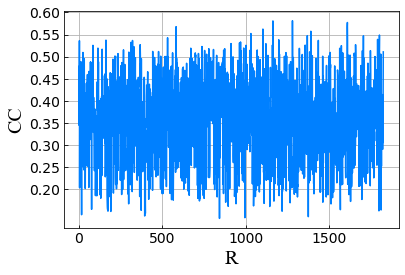

In [4]:
s=0
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 20,
         }
plt.xlabel('R',font1)
plt.ylabel('CC',font1)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(np.arange(s,len(train_img),1),n5,color=(0,0.5,1), linewidth=1.5)
plt.grid(True)
plt.xticks(np.arange(s,len(train_img), 500))
plt.yticks(np.arange(0.2,0.6+0.05,0.05))
# plt.xlim([s,2])

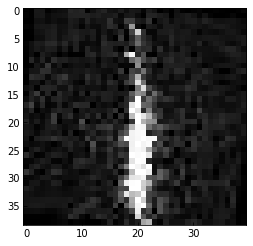

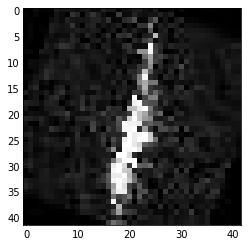

In [20]:
#第一张测试图片
plt.figure()
plt.imshow(test_img[0])
plt.show()
plt.figure()
#训练集中 与第一张测试图片CC最高的图像
index_of_max_value=n5.index(max(n5))
plt.imshow(train_img[index_of_max_value])
plt.show()

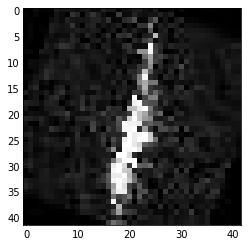

In [17]:
index_of_max_value=n5.index(max(n5))
plt.imshow(train_img[index_of_max_value])
plt.show()